## 1. Importing Necessary Libraries ##

In [ ]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation , Embedding, GlobalMaxPooling1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5524690035777261146
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16333164217071147959
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13139201422036473092
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14958751662410047389
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## 2. Reading and Visualization of the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
main_directory = '/content/drive/My Drive/My Works/Bangla YouTube/Emotion.csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
dataset = pd.read_csv(main_directory,encoding = 'utf-8',sep=';')
dataset.head()

,id,text,emotion,lan,domain
0,2275,Hands down. You are good. I mean smart good.,joy,EN,funny_video
1,2283,Your are very good. keep it up,none,EN,funny_video
2,2292,Man!! I will never get used to these videos of...,surprise,EN,funny_video
3,2293,ডিসলাইক দেয়া 32,none,BN,funny_video
4,2298,ব্যাপক বিনোদন।,joy,BN,funny_video


In [ ]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,id,text,emotion,lan,domain
0,7321,যারা দেয় অইগুলা সব সাবরিনা ন্যান্সির ফ্যান :P\n,disgust,BN,music_video
1,8625,Welcome vaia💜\n,joy,RN,review_video
2,8305,"ভাল লাগল,ধন্যবাদ তুষার ভাই,\n",joy,BN,review_video
3,16158,Excellent work and nice story Nisho and tanjin...,joy,EN,drama_video
4,9027,shala ekta kothin jinish\n,disgust,RN,report_video


In [ ]:
# Get indexes where name column has value john
indexNames = dataset[(dataset['lan'] == 'EN') | (dataset['lan'] == 'BN')].index

# Delete these row indexes from dataFrame
dataset = dataset.drop(indexNames)

In [ ]:
dataset.head()

,id,text,emotion,lan,domain
1,8625,Welcome vaia💜\n,joy,RN,review_video
4,9027,shala ekta kothin jinish\n,disgust,RN,report_video
11,18082,Apni khelar kechui to bujen na agee sekhen tar...,disgust,RN,sports_video
14,4423,shesher kahini ta thik holo na\n,sad,RN,drama_video
15,27116,sakil Khan naice song supar 👌💔👌\n,joy,RN,music_video


In [ ]:
emotion = np.array(dataset['emotion'])

In [ ]:
class_values = dataset['emotion'].unique()
print(class_values)

['joy' 'disgust' 'sad' 'anger' 'none' 'surprise' 'others' 'fear']


In [ ]:
dataset.groupby('emotion')['text'].count()

emotion
anger       116
disgust     225
fear          5
joy         349
none        315
others        2
sad          72
surprise     53
Name: text, dtype: int64

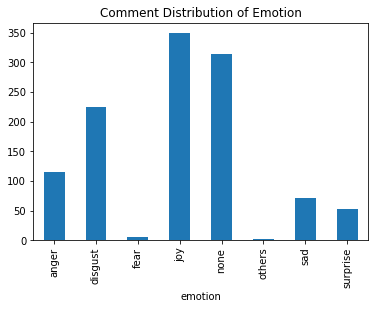

In [ ]:
dataset.groupby('emotion')['text'].count().plot(kind='bar' , title= 'Comment Distribution of Emotion')

In [ ]:
dataset['text']
dataset.head()

,id,text,emotion,lan,domain
1,8625,Welcome vaia💜\n,joy,RN,review_video
4,9027,shala ekta kothin jinish\n,disgust,RN,report_video
11,18082,Apni khelar kechui to bujen na agee sekhen tar...,disgust,RN,sports_video
14,4423,shesher kahini ta thik holo na\n,sad,RN,drama_video
15,27116,sakil Khan naice song supar 👌💔👌\n,joy,RN,music_video


In [ ]:
def plot_model(history):
    # Plot training & validation accuracy values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy',linewidth=3.0)
    plt.plot(x, val_acc, 'r', label='Validation accuracy',linewidth=3.0)
    plt.title('Training and validation accuracy',fontsize=18)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss',linewidth=3.0)
    plt.plot(x, val_loss, 'r', label='Validation loss',linewidth=3.0)
    plt.title('Training and validation loss', fontsize=18)
    plt.legend()


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 3. Label Encoding & Vectorization


In [ ]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(emotion)

print(label_encoder.classes_)

label_OneHotEncoder = OneHotEncoder()
encoded_label = label_OneHotEncoder.fit_transform(encoded_label.reshape(-1,1)).toarray()

['anger' 'disgust' 'fear' 'joy' 'none' 'others' 'sad' 'surprise']


In [ ]:
vocabulary_size = 10000
input_length = 30

In [ ]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])
data = pad_sequences(sequences, maxlen = input_length)

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(data, encoded_label, test_size = 0.2)

In [ ]:
num_classes = len(class_values)
validation_split = 0.2

# 4. Model Creation & Training

# LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000


validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,activation='tanh'))
model_lstm.add(Dense(num_classes, activation='softmax'))
model_lstm.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 1000)          10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               440400    
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
Total params: 10,441,208
Trainable params: 10,441,208
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_lstm.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, batch_size=4,
                    shuffle = True, callbacks = callback)

Epoch 1/100
182/182 [==============================] - 35s 190ms/step - loss: 0.3056 - accuracy: 0.3824 - f1_m: 0.0928 - precision_m: 0.1900 - recall_m: 0.0659 - val_loss: 0.2932 - val_accuracy: 0.4451 - val_f1_m: 0.1675 - val_precision_m: 0.3514 - val_recall_m: 0.1141
Epoch 2/100
182/182 [==============================] - 34s 189ms/step - loss: 0.2032 - accuracy: 0.6657 - f1_m: 0.5981 - precision_m: 0.7953 - recall_m: 0.5046 - val_loss: 0.2930 - val_accuracy: 0.4505 - val_f1_m: 0.3795 - val_precision_m: 0.5109 - val_recall_m: 0.3207
Epoch 3/100
182/182 [==============================] - 34s 186ms/step - loss: 0.1056 - accuracy: 0.8432 - f1_m: 0.8316 - precision_m: 0.8938 - recall_m: 0.7908 - val_loss: 0.3247 - val_accuracy: 0.4066 - val_f1_m: 0.3182 - val_precision_m: 0.4058 - val_recall_m: 0.2717
Epoch 4/100
182/182 [==============================] - 34s 186ms/step - loss: 0.0662 - accuracy: 0.8996 - f1_m: 0.9030 - precision_m: 0.9336 - recall_m: 0.8814 - val_loss: 0.3678 - val_accur

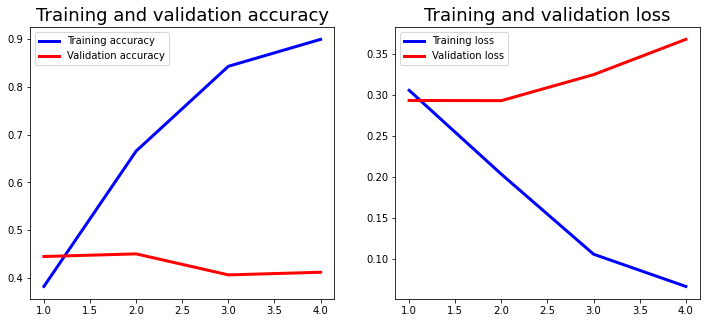

In [ ]:
plot_model(history)

In [ ]:
model_lstm.evaluate(test_data, test_label, verbose = 1)

8/8 [==============================] - 0s 13ms/step - loss: 0.3260 - accuracy: 0.4386 - f1_m: 0.4056 - precision_m: 0.5809 - recall_m: 0.3242


[0.32604870200157166,
 0.4385964870452881,
 0.4056115448474884,
 0.5808523893356323,
 0.32421875]

In [ ]:
model_lstm.save('/content/drive/My Drive/My Works/Bangla YouTube/model_lstm_banglish.h5')

# Stacked LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 128
l2_lstm_units = 64

validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model = Sequential()

model.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model.add(Dense(dense_input, activation='relu'))

model.add(LSTM(l1_lstm_units, dropout = l1_dropout, recurrent_dropout = l1_recurrent_dropout, 
                             return_sequences = True, activation='relu'))
model.add(LSTM(l2_lstm_units, dropout = l2_dropout, recurrent_dropout = l2_recurrent_dropout, 
                             return_sequences = False, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 1000)          10000000  
_________________________________________________________________
dense_1 (Dense)              (None, 30, 1000)          1001000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           578048    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 11,628,976
Trainable params: 11,628,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, batch_size=4,
                    shuffle = True, callbacks = callback)



Epoch 1/100
182/182 [==============================] - 55s 302ms/step - loss: 0.8120 - accuracy: 0.2944 - f1_m: 0.0584 - precision_m: 0.0636 - recall_m: 0.0563 - val_loss: 0.3117 - val_accuracy: 0.2912 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
182/182 [==============================] - 54s 299ms/step - loss: 0.2869 - accuracy: 0.4154 - f1_m: 0.0990 - precision_m: 0.2106 - recall_m: 0.0678 - val_loss: 0.2920 - val_accuracy: 0.4505 - val_f1_m: 0.1362 - val_precision_m: 0.2826 - val_recall_m: 0.0924
Epoch 3/100
182/182 [==============================] - 54s 297ms/step - loss: 0.2488 - accuracy: 0.6121 - f1_m: 0.4775 - precision_m: 0.7239 - recall_m: 0.3819 - val_loss: 0.2974 - val_accuracy: 0.4011 - val_f1_m: 0.1762 - val_precision_m: 0.3732 - val_recall_m: 0.1196
Epoch 4/100
182/182 [==============================] - 54s 297ms/step - loss: 0.1664 - accuracy: 0.7194 - f1_m: 0.6714 - precision_m: 0.8906 - recall_m: 0.5668 - val_loss: 0.3117

In [ ]:
model.evaluate(test_data, test_label, verbose = 1)

8/8 [==============================] - 0s 21ms/step - loss: 0.3090 - accuracy: 0.4474 - f1_m: 0.3769 - precision_m: 0.6044 - recall_m: 0.2812


[0.30903923511505127,
 0.44736841320991516,
 0.3769368529319763,
 0.6044060587882996,
 0.28125]

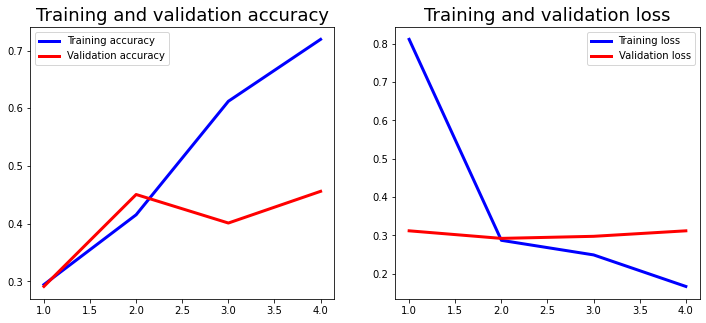

In [ ]:
plot_model(history)

In [ ]:
model.save('/content/drive/My Drive/My Works/Bangla YouTube/model_stacked_lstm_banglish.h5')